In [1]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [2]:
# main functions to import from src
from src import GGB_Statements, get_model_shortname, ring_csv_to_df, ring_to_roundrobin_df

from visualization_functions import plot_by_question, human_kde, h2, plot_IH_v_IB

Questions already have IDs


In [3]:
# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/OUS.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/OUSinverted.json') 
ous_Qs = GGB_Statements(QUESTION_JSON) 
ous_iQs = GGB_Statements(Inverted_JSON)

In [4]:
ous_ring_csvs = glob.glob('results_ous_multi/**_ensemble_**_q1-9_n5.csv')

In [5]:
ring_rr_df = pd.DataFrame()
ring_df = pd.DataFrame()
for csv_file in ous_ring_csvs:
    if 'inverted' in csv_file:
        current_Qs = ous_iQs
    else:
        current_Qs = ous_Qs
    
    df = ring_csv_to_df(csv_file, current_Qs)
    ring_df = pd.concat([ring_df, df])
    rr_df = ring_to_roundrobin_df(df, current_Qs)
    ring_rr_df = pd.concat([ring_rr_df, rr_df], ignore_index=True)

# add the ous question number:
ring_rr_df['ous_question_id'] = ring_rr_df['question_id'].apply(lambda x: x % 100)

In [7]:
ring_by_question = ring_rr_df.groupby(['chat_type', 'question_id','question_num','category', 'ous_question_id', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column
ring_by_category = ring_rr_df.groupby(['chat_type', 'category', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

In [8]:
round_4_rr_df = ring_rr_df[ring_rr_df['round'] == 4]

In [9]:
round_4_deepseek = round_4_rr_df[(round_4_rr_df['category'] == 'IH') & (round_4_rr_df['chat_type'].apply(lambda x: 'deepseek' in x))]


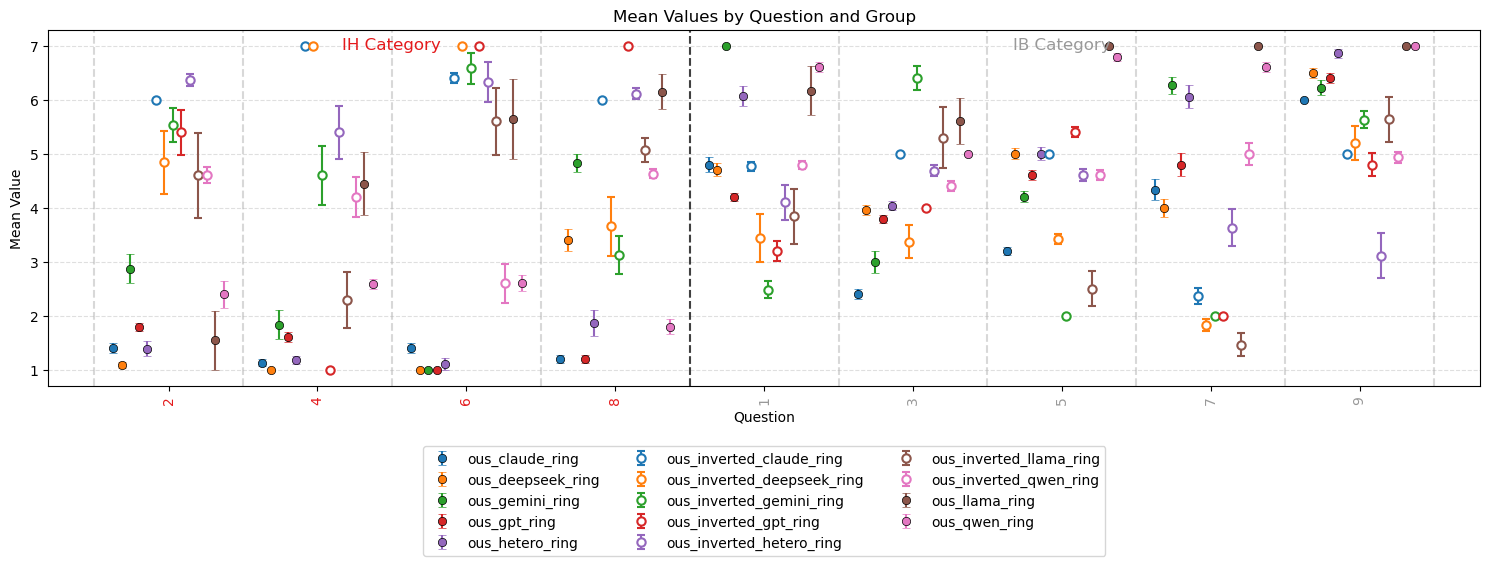

In [11]:
f = plot_by_question(data = ring_by_question[ring_by_question['round'] == 4], group_by = 'chat_type', category_order=['IH','IB'], 
    match_inverted_colors=True,
    inverted_indicator='inverted', error_col= 'sem')

ax = f.axes[0]  # Get the axes from the figure
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()  # Adjust layout to accommodate the legend

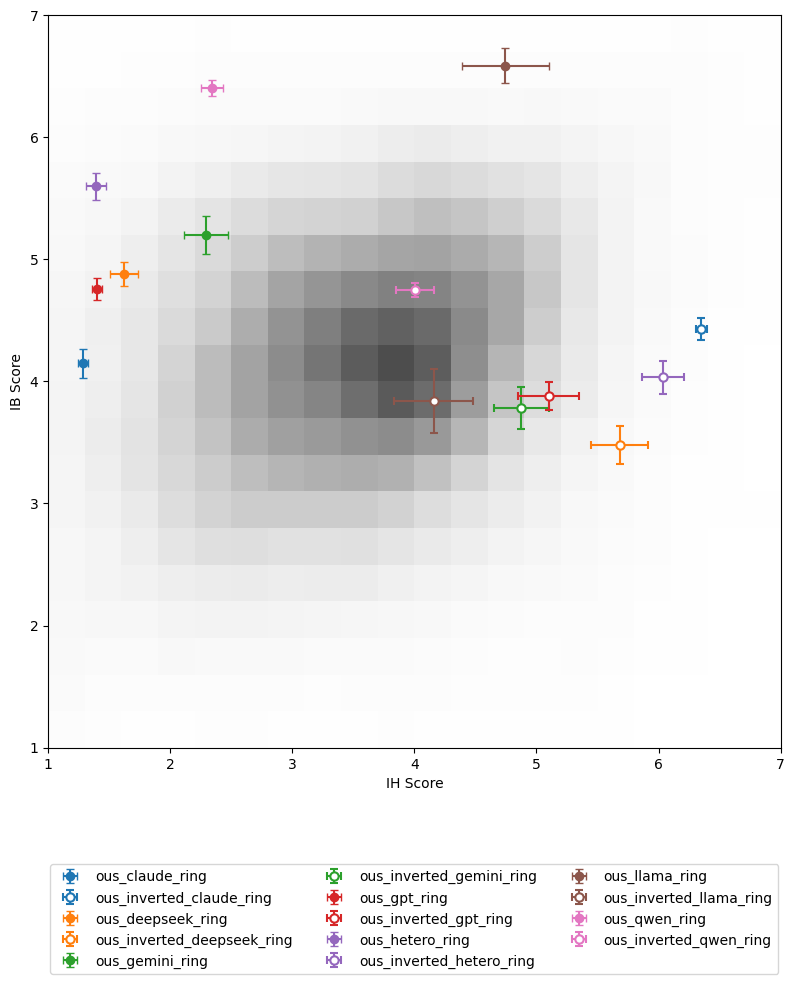

In [12]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = False)

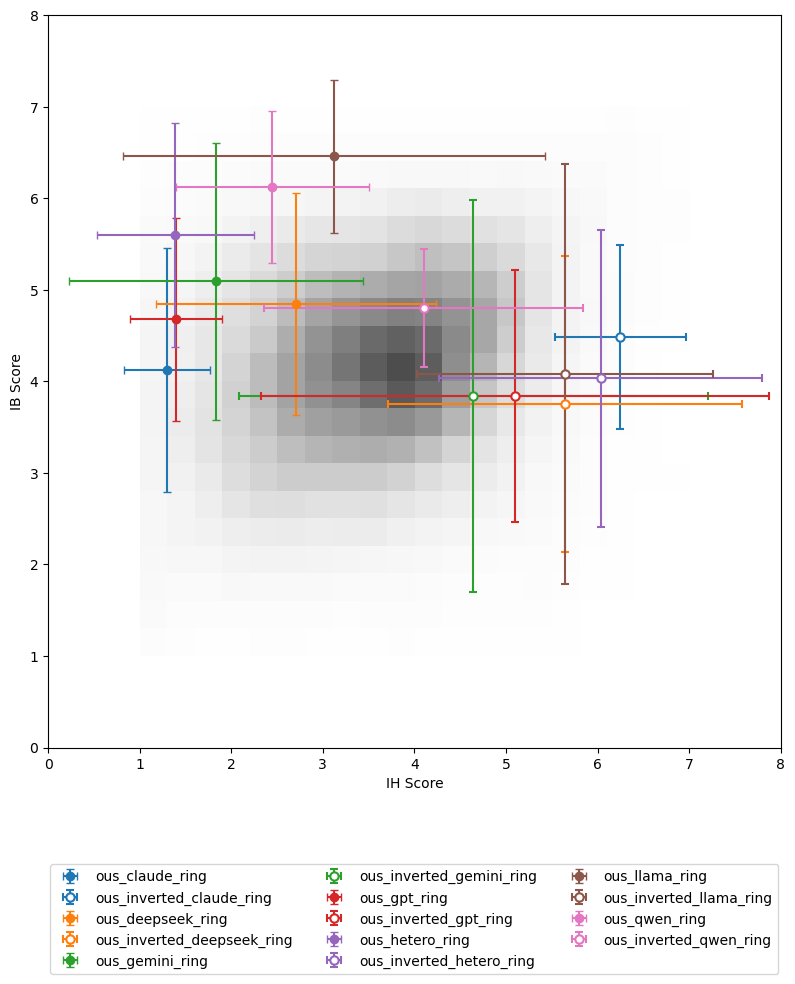

In [26]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = True,ax_lims=[0,8])

In [23]:
from visualization_functions import plot_rr_round

In [27]:
ring_rr_df

,question_num,question_id,round,message_index,agent_name,agent_model,agent_answer_str,agent_fullresponse,repeat_index,agent_answer,category,chat_type,ous_question_id
0,1,305,1,1,agent_deepseek_deepseek_chat_v3_0324_0_0,deepseek/deepseek-chat-v3-0324,6,Rationale Answer: While self-preservation is a...,2,6.0,IB,ous_inverted_deepseek_ring,5
1,1,305,2,2,agent_deepseek_deepseek_chat_v3_0324_0_1,deepseek/deepseek-chat-v3-0324,No answer found,,2,NaN,IB,ous_inverted_deepseek_ring,5
2,1,305,3,3,agent_deepseek_deepseek_chat_v3_0324_0_2,deepseek/deepseek-chat-v3-0324,6,Rationale Answer: The moral duty to save a lif...,2,6.0,IB,ous_inverted_deepseek_ring,5
3,1,305,4,4,agent_deepseek_deepseek_chat_v3_0324_0_3,deepseek/deepseek-chat-v3-0324,No answer found,,2,NaN,IB,ous_inverted_deepseek_ring,5
4,2,301,1,1,agent_deepseek_deepseek_chat_v3_0324_0_0,deepseek/deepseek-chat-v3-0324,5,Rationale Answer: Prioritizing the suffering o...,2,5.0,IH,ous_inverted_deepseek_ring,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,8,204,4,4,agent_google_gemini_2_0_flash_lite_001_0_3,google/gemini-2.0-flash-lite-001,No answer found,,6,NaN,IH,ous_gemini_ring,4
4268,9,209,1,1,agent_google_gemini_2_0_flash_lite_001_0_0,google/gemini-2.0-flash-lite-001,{6},Rationale Answer: I believe that while there i...,6,6.0,IB,ous_gemini_ring,9
4269,9,209,2,2,agent_google_gemini_2_0_flash_lite_001_0_1,google/gemini-2.0-flash-lite-001,{6},Rationale Answer: Keeping money without donati...,6,6.0,IB,ous_gemini_ring,9
4270,9,209,3,3,agent_google_gemini_2_0_flash_lite_001_0_2,google/gemini-2.0-flash-lite-001,{6},Rationale Answer: Holding onto money that coul...,6,6.0,IB,ous_gemini_ring,9


(<Figure size 2250x3600 with 1 Axes>, <Axes: title={'center': 'Round 4'}>)

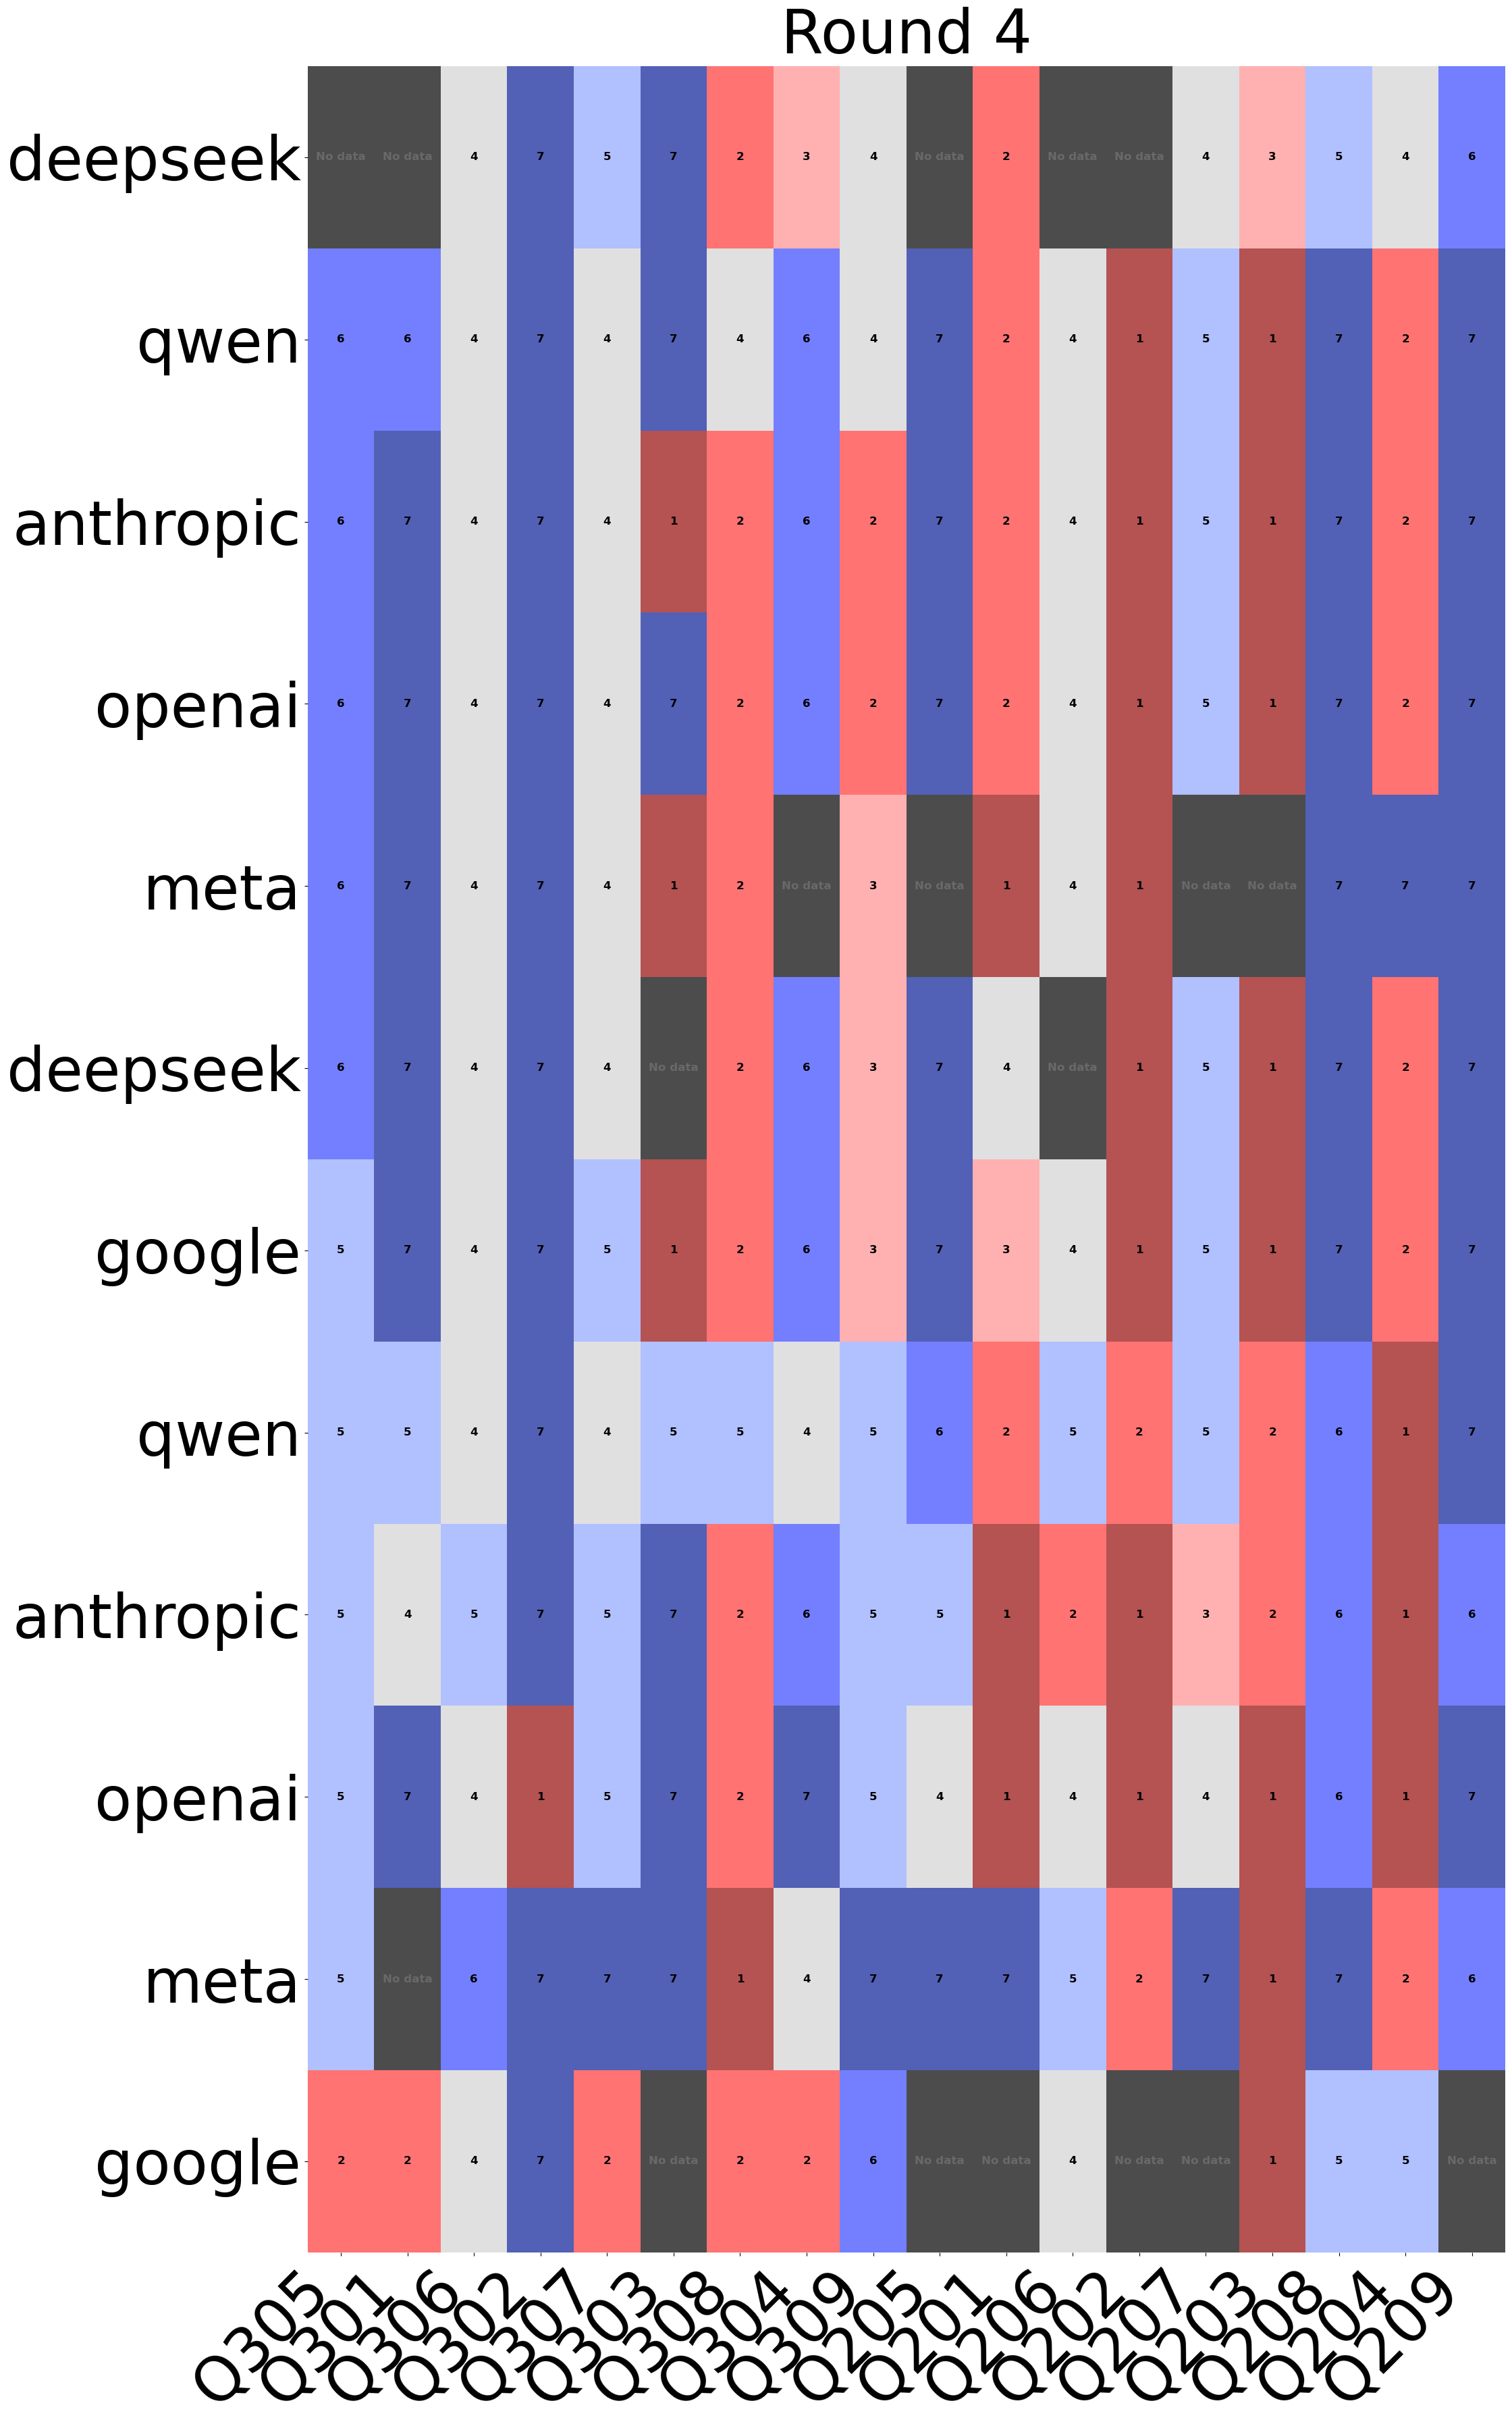

In [ ]:
plot_rr_round(ring_rr_df, round = 4)
# TODO: average over rounds!
# TODO: why is it repeating 2x (there should be 5 repeats??)